## Load Data

In [1]:
# Import python packages
import re
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

There are several warning in the code. I will hide them for now and deal with them later.

In [2]:
# Hide warning
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Read business data and checkin data
clean_business = pd.read_csv('clean_business.csv')

In [4]:
# Make a copy of raw dataset
df_business = clean_business.copy()

In [5]:
# Reveal first few rows 
df_business.head()

,attributes,business_id,categories,city,latitude,longitude,name,postal_code,review_count,stars,state,isBankrupt,county
0,"{'RestaurantsTableService': False, 'GoodForMea...",rDMptJYWtnMhpQu_rRXHng,"['Fast Food', 'Burgers', 'Restaurants']",Phoenix,33.607070,-112.064382,McDonald's,85022,10,1.0,AZ,0,Maricopa County
1,"{'RestaurantsTableService': True, 'GoodForMeal...",1WBkAuQg81kokZIPMpn9Zg,"['Burgers', 'Restaurants']",Phoenix,33.607310,-112.063404,Charr An American Burger Bar,85022,232,3.0,AZ,0,Maricopa County
2,"{'RestaurantsTableService': False, 'GoodForMea...",iPa__LOhse-hobC2Xmp-Kw,"['Restaurants', 'Burgers', 'Fast Food']",Phoenix,33.508765,-112.046240,McDonald's,85016,34,3.0,AZ,0,Maricopa County
3,"{'BusinessAcceptsCreditCards': True, 'Business...",YhV93k9uiMdr3FlV4FHjwA,"['Marketing', ""Men's Clothing"", 'Restaurants',...",Phoenix,33.449967,-112.070222,Caviness Studio,85001,4,5.0,AZ,0,Maricopa County
4,"{'Alcohol': 'full_bar', 'HasTV': True, 'NoiseL...",VdlPZg2NAu8t8GkdbPLecg,"['Restaurants', 'Gluten-Free', 'Indian', 'Seaf...",Scottsdale,33.555212,-111.900456,Tandoori Times Indian Bistro,85258,263,3.5,AZ,0,Maricopa County


In [6]:
df_business.shape

(7116, 13)

## Feature Extraction Preprocess

In [7]:
# Convert types of attributes and categories to dictionary and list
df_business['attributes'] = df_business['attributes'].apply(lambda x: eval(x))
df_business['categories'] = df_business['categories'].apply(lambda x: eval(x))

## Extract Features: isChain

In [8]:
# Create new feature chain
dict_chain = df_business['name'].value_counts().to_dict()
df_business['isChain'] = df_business['name'].apply(lambda x: int(dict_chain[x] > 1))

## Extract Features: Density

### Use City As Cut-Off Line

In [9]:
# Create a dictionary to store restuarant number in each city
city_dict = df_business.groupby('city').apply(len).to_dict()

In [10]:
# Create new feature neighborhood_city
df_business['density'] = df_business['city'].apply(lambda city: city_dict.get(city))

### Use Distance As Cut-off Line

To create the neighborhood feature by distance, we need first `calculate the distance between one restaurant and all other restaurant`. And for restaurants which have the distance less than certain mile, we `mark` them as the neighborhood as each other. For each restaurant, we will calculate the `total number of neighborhood` it has.

In [11]:
# Define a function to calculate the distance
from geopy.distance import geodesic

def distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).miles

## Extract Features From Category

In [12]:
# Extract all words in categories
categories = np.unique([item for row in df_business['categories'] for item in row])
print("Number of unique words in feature 'categories':", len(categories))

Number of unique words in feature 'categories': 417


Since the words in `categories` list is not much, we will do manually check and split the words in three sub categories. 

### Manually Split

Ethnics: <br>
'Afghan', 'African', 'American (New)','American (Traditional)', 'Arabian', 'Argentine','Armenian','Asian Fusion','Australian', <br> 
'Austrian','Belgian','Brazilian', 'British','Cajun/Creole', 'Cambodian','Cantonese', 'Caribbean','Chinese','Colombian',<br>'Indian','Cuban','Czech','Dominican','Empanadas','Ethiopian','Filipino','French','German','Greek','Hawaiian', 'Irish',<br>'Italian','Japanese', 'Korean','Kosher','Halal','Laotian','Latin American','Lebanese', 'Malaysian','Mediterranean','Mexican',<br>'Middle Eastern', 'Modern European', 'Mongolian','Moroccan','Pakistani', 'Persian/Iranian','Peruvian','Puerto Rican',<br>'Russian',
'Salvadoran','Scandinavian','Southern', 'Spanish','Szechuan', 'Taiwanese','Thai','Tex-Mex',
'Trinidadian',<br>'Vietnamese','Turkish','Ukrainian','Uzbek'

Types:<br>
'Acai Bowls', 'Bagels','Bubble Tea','Burgers', 'Cheesesteaks','Chicken Wings','Creperies','Cupcakes',
         'Custom Cakes',<br>'Do-It-Yourself Food','Donuts','Falafel','Fish & Chips','Fondue',
         'Fruits & Veggies','Gelato','Gluten-Free', 'Hot Dogs', <br>'Hot Pot', 'Ice Cream & Frozen Yogurt', 
         'Imported Food','Juice Bars & Smoothies', 'Kebab','Live/Raw Food','Local Flavor',<br> 'Macarons','Noodles',
         'Pita', 'Pizza', 'Poutineries','Sandwiches','Pretzels','Ramen','Rotisserie Chicken','Salad',
         'Seafood',<br>'Shaved Ice', 'Shaved Snow', 'Soup', 'Tacos', 'Teppanyaki',
         'Waffles', 'Wraps','Bakeries', 'Barbeque', 'Beverage Store',<br>'Buffets','Cafes',
         'Cafeteria', 'Candy Stores','Caterers', 'Cheese Shops','Chicken Shop','Chocolatiers & Shops',<br>
         'Coffee & Tea', 'Coffee & Tea Supplies', 'Coffee Roasteries','Coffeeshops','Desserts',
         'Dim Sum','Delis','Fast Food',<br>'Food Court','Food Stands','Food Trucks','Hotels',
         'Hotels & Travel','Internet Cafes', 'New Mexican Cuisine',<br>
         'Organic Stores', 'Pan Asian','Pasta Shops','Patisserie/Cake Shop', 'Popcorn Shops', 'Seafood Markets',
         'Steakhouses',<br>'Tea Rooms', 'Themed Cafes','Vegan', 'Vegetarian'

Alchohol related types: <br>
'Bars','Beer', 'Beer Bar','Beer Gardens', 'Brasseries', 'Breweries', 'Brewpubs','Champagne Bars','Cocktail Bars',<br>'Distilleries','Dive Bars','Gay Bars', 'Gastropubs','Hotel bar','Izakaya', 'Irish Pub','Piano Bars', 'Pubs','Speakeasies',<br>'Sports Bars', 'Sushi Bars','Tapas Bars','Whiskey Bars','Wine & Spirits','Wine Bars', 'Wineries'

Time:
'Bed & Breakfast', 'Breakfast & Brunch', 'Diners', 'Dinner Theater', 'Nightlife'

Attention: 'cinema', 'Food Delivery Services','Gas Stations''Kids Activities', Alchohol related types

### Restaurant categories I - By Counties or Areas

In [13]:
ethnics = ['Afghan', 'African', 'American (New)','American (Traditional)', 'Arabian', 'Argentine',
           'Armenian','Asian Fusion','Australian', 'Austrian','Belgian','Brazilian', 'British',
           'Cajun/Creole', 'Cambodian','Cantonese', 'Caribbean','Chinese','Colombian', 'Indian',
           'Cuban','Czech','Dominican','Empanadas','Ethiopian','Filipino','French','German','Greek',
           'Hawaiian', 'Irish','Italian', 'Japanese', 'Korean','Kosher','Halal','Laotian','Latin American',
           'Lebanese', 'Malaysian','Mediterranean','Mexican','Middle Eastern', 'Modern European', 'Mongolian',
           'Moroccan','Pakistani', 'Persian/Iranian','Peruvian','Puerto Rican','Russian', 'Salvadoran',
           'Scandinavian','Southern', 'Spanish','Szechuan', 'Taiwanese','Thai','Tex-Mex', 'Trinidadian',
           'Vietnamese','Turkish','Ukrainian', 'Uzbek']

In [14]:
# Create new feature ethnics
df_business['ethnics'] = df_business['categories'].apply(lambda row: [x for x in row if x in ethnics])
df_business['ethnics'].value_counts();# Reveal if necessary

In [15]:
# Create a dictionary to store the appear times of each ethnics
ethnics_dict = dict(zip(ethnics, [sum([x in row for row in df_business['ethnics']]) for x in ethnics]))
print('Total Number of Ethnics:', len(ethnics_dict))

Total Number of Ethnics: 64


In [16]:
# Convert dictionary to dataframe
ethnics_df = pd.DataFrame(list(ethnics_dict.items()),columns=['Ethnics','Count']).sort_values('Count',ascending = False).reset_index()
ethnics_df = ethnics_df.drop('index', axis=1)

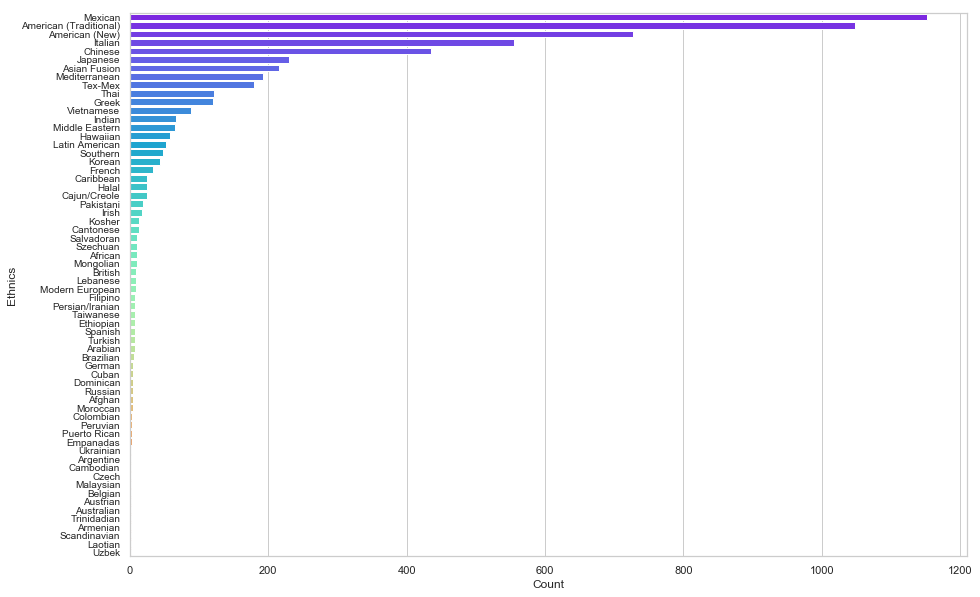

In [17]:
# Visualize dataframe ethnics
plt.figure(figsize=(15,10))
sns.set(style='whitegrid')
ethnics_plot = sns.barplot(x='Count', y='Ethnics', data=ethnics_df,palette ='rainbow')
ethnics_plot.set_yticklabels(ethnics_plot.get_yticklabels(), fontdict={'fontsize':10});

64 ethnics are too many to us to analyze directly. Therefore, we will combine related ethnics to groups to reduce the number of ethnics.

In [18]:
ethnic_dict = {
'MiddleEast': ['Arabian', 'Armenian', 'Halal','Lebanese','Middle Eastern','Turkish','Mediterranean',
              'Afghan','Pakistani','Persian/Iranian'],
'African': ['African', 'Ethiopian', 'Moroccan'],
'American': ['American (New)', 'American (Traditional)','Hawaiian','Southern'],
'European': ['Austrian', 'Belgian', 'British', 'Czech','French','German','Greek','Irish','Italian',
               'Kosher','Modern European','Cajun/Creole','Scandinavian','Spanish','Australian'],
'Chinese': ['Cantonese', 'Chinese','Szechuan','Taiwanese'],
'LatinAmerica': ['Argentine', 'Brazilian', 'Caribbean', 'Colombian', 'Cuban', 'Dominican', 'Empanadas',
                     'Latin American', 'Peruvian', 'Puerto Rican', 'Salvadoran', 'Trinidadian'],
'SouthEastAisa': ['Cambodian', 'Filipino','Laotian', 'Malaysian', 'Thai', 'Vietnamese','Indian'],
'EastAsia': ['Japanese', 'Korean', 'Asian Fusion'],
'Mexican': ['Mexican','Tex-Mex'],
'AsiaContinent': ['Mongolian','Russian','Ukrainian','Uzbek']
}

In [19]:
for ethnic in ethnic_dict.keys():
    df_business['ethnics'] = df_business['ethnics'].apply(lambda row: np.unique([ethnic if x in ethnic_dict[ethnic]
                                                                       else x for x in row]))

In [20]:
# update the dictionary
ethnics = ['MiddleEast','African','American','European','Chinese','LatinAmerica','SouthEastAisa',
           'EastAsia','Mexican','AsiaContinent']
ethnics_dict = dict(zip(ethnics, [sum([x in row for row in df_business['ethnics']]) for x in ethnics]))
print('Total Number of Ethnics:', len(ethnics_dict))

Total Number of Ethnics: 10


In [21]:
# Convert dictionary to dataframe
ethnics_df = pd.DataFrame(list(ethnics_dict.items()),columns=['Ethnics','Count']).sort_values('Count',ascending = False).reset_index()
ethnics_df = ethnics_df.drop('index', axis=1)

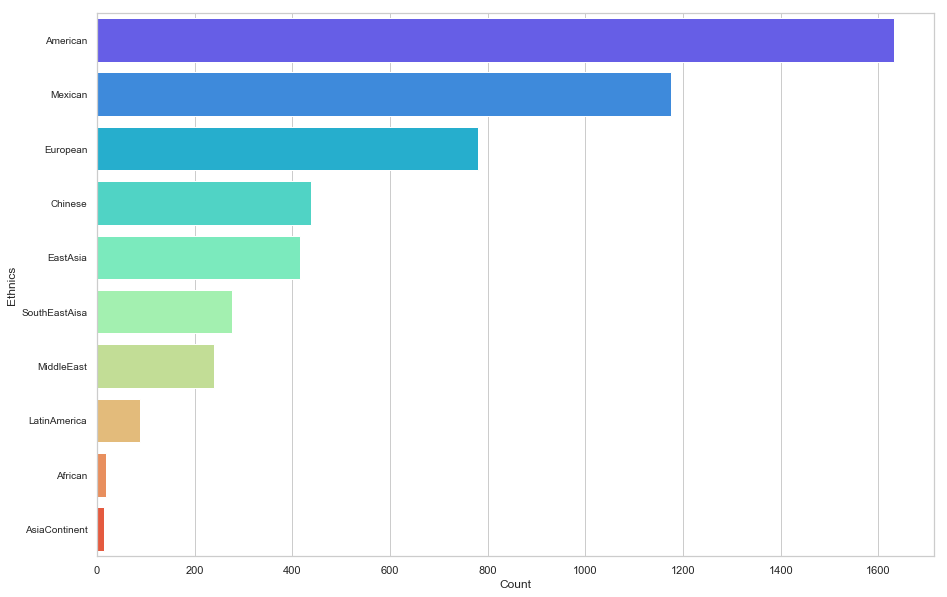

In [22]:
# Visualize dataframe ethnics
plt.figure(figsize=(15,10))
sns.set(style='whitegrid')
ethnics_plot = sns.barplot(x='Count', y='Ethnics', data=ethnics_df, palette ='rainbow')
ethnics_plot.set_yticklabels(ethnics_plot.get_yticklabels(), fontdict={'fontsize':10});

In [23]:
df_business['ethnics'].head(10)

0                 []
1                 []
2                 []
3                 []
4    [SouthEastAisa]
5         [American]
6                 []
7                 []
8         [EastAsia]
9    [SouthEastAisa]
Name: ethnics, dtype: object

### Restaurant categories II - By Various Types

We use the types from `Machine Learning and Visualization with Yelp Dataset` directly.

In [24]:
types = ['Acai Bowls', 'Bagels','Bubble Tea','Burgers', 'Cheesesteaks','Chicken Wings','Creperies','Cupcakes',
         'Custom Cakes','Do-It-Yourself Food','Donuts','Falafel','Fish & Chips','Fondue','Fruits & Veggies',
         'Gelato','Gluten-Free', 'Hot Dogs', 'Hot Pot', 'Ice Cream & Frozen Yogurt', 
         'Imported Food','Juice Bars & Smoothies', 'Kebab','Live/Raw Food','Local Flavor', 'Macarons','Noodles',
         'Pita', 'Pizza', 'Poutineries','Sandwiches','Pretzels','Ramen','Rotisserie Chicken','Salad',
         'Seafood','Shaved Ice', 'Shaved Snow', 'Soup', 'Tacos', 'Teppanyaki',
         'Waffles', 'Wraps','Bakeries', 'Barbeque', 'Beverage Store', 'Buffets','Cafes',
         'Cafeteria', 'Candy Stores','Caterers', 'Cheese Shops','Chicken Shop','Chocolatiers & Shops',
         'Coffee & Tea', 'Coffee & Tea Supplies', 'Coffee Roasteries','Coffeeshops','Desserts',
         'Dim Sum','Delis','Fast Food','Food Court','Food Stands','Food Trucks','Hotels',
         'Hotels & Travel','Internet Cafes', 'New Mexican Cuisine',
         'Organic Stores', 'Pan Asian','Pasta Shops','Patisserie/Cake Shop', 'Popcorn Shops', 'Seafood Markets',
         'Steakhouses','Sushi Bars','Tea Rooms', 'Themed Cafes','Vegan', 'Vegetarian',
         'Bars','Beer', 'Beer Bar','Beer Gardens','Brasseries', 'Breweries', 'Brewpubs','Champagne Bars',
         'Cocktail Bars','Distilleries','Dive Bars','Gay Bars', 'Gastropubs','Hotel bar','Izakaya','Irish Pub',
         'Piano Bars', 'Pubs','Speakeasies','Sports Bars','Tapas Bars','Whiskey Bars','Wine & Spirits','Wine Bars',
         'Wineries']

In [25]:
# Create new feature types
df_business['types'] = df_business['categories'].apply(lambda row: [x for x in row if x in types])

In [26]:
# Create a dictionary to store the appear times of each types
types_dict = dict(zip(types, [sum([x in row for row in df_business['types']]) for x in types]))
print('Total Number of Types:', len(types_dict))

Total Number of Types: 106


Same with `ethnics`, we will group words for feature `type`.

In [27]:
type_dict = {
    'Fast Food': ['Burgers','Fish & Chips','Hot Dogs','Sandwiches','Fast Food'],
    'Alcohol': ['Bars','Beer', 'Beer Bar','Beer Gardens','Brasseries', 'Breweries', 'Brewpubs','Champagne Bars',
                'Cocktail Bars','Distilleries','Dive Bars','Gay Bars', 'Gastropubs','Hotel bar','Izakaya',
                'Irish Pub','Piano Bars', 'Pubs','Speakeasies','Sports Bars','Tapas Bars','Whiskey Bars',
                'Wine & Spirits','Wine Bars', 'Wineries'],
    'Beverage': ['Bubble Tea','Juice Bars & Smoothies','Beverage Store'],
    'Bakeries & Desserts': ['Bagels','Cupcakes','Custom Cakes','Patisserie/Cake Shop','Shaved Ice','Shaved Snow',
                            'Gelato','Ice Cream & Frozen Yogurt','Macarons','Chocolatiers & Shops','Donuts',
                            'Waffles','Bakeries','Desserts','Creperies'],
    'Vegetarian': ['Fruits & Veggies','Vegan','Vegetarian','Falafel','Acai Bowls'],
    'Coffee & Tea': ['Coffee Roasteries','Coffeeshops','Tea Rooms','Coffee & Tea','Coffee & Tea Supplies','Cafes',
                    'Internet Cafes','Themed Cafes'],
    'Noodles': ['Noodles','Ramen','Pasta Shops'],
    'Seafood': ['Seafood Markets','Seafood'],
    'Snacks': ['Pretzels','Candy Stores','Popcorn Shops'],
    'Chicken': ['Rotisserie Chicken','Chicken Shop','Chicken Wings'],
    'Meat': ['Barbeque','Delis','Steakhouses','Cheesesteaks'],
    'Asian Ethnics': ['Hot Pot','Kebab','Teppanyaki','Dim Sum','Pan Asian','Sushi Bars'],
    'SpecialLocations': ['Food Stands','Food Trucks','Food Court','Hotels','Hotels & Travel']
}

In [28]:
Other = ['Do-It-Yourself Food','Fondue','Gluten-Free',
              'Imported Food','Live/Raw Food','Local Flavor','Pita', 'Pizza', 'Poutineries','Salad','Soup',
              'Tacos', 'Wraps','Buffets','Cafeteria','Caterers','Cheese Shops', 'New Mexican Cuisine',
              'Organic Stores']

In [29]:
for tp in type_dict.keys():
    df_business['types'] = df_business['types'].apply(lambda row: np.unique([tp if x in type_dict[tp]
                                                                       else x for x in row]))

In [30]:
# update the dictionary
types = ['Fast Food','Alcohol','Beverage','Bakeries & Desserts','Vegetarian','Coffee & Tea','Noodles','Seafood',
        'Snacks','Chicken','Meat','Asian Ethnics','SpecialLocations'] + Other
type_dict = dict(zip(types, [sum([x in row for row in df_business['types']]) for x in types]))
print('Total Number of Types:', len(type_dict))

Total Number of Types: 32


In [31]:
# Convert dictionary to dataframe
type_df = pd.DataFrame(list(type_dict.items()),columns=['Type','Count']).sort_values('Count',ascending = False).reset_index()
type_df = type_df.drop('index', axis=1)

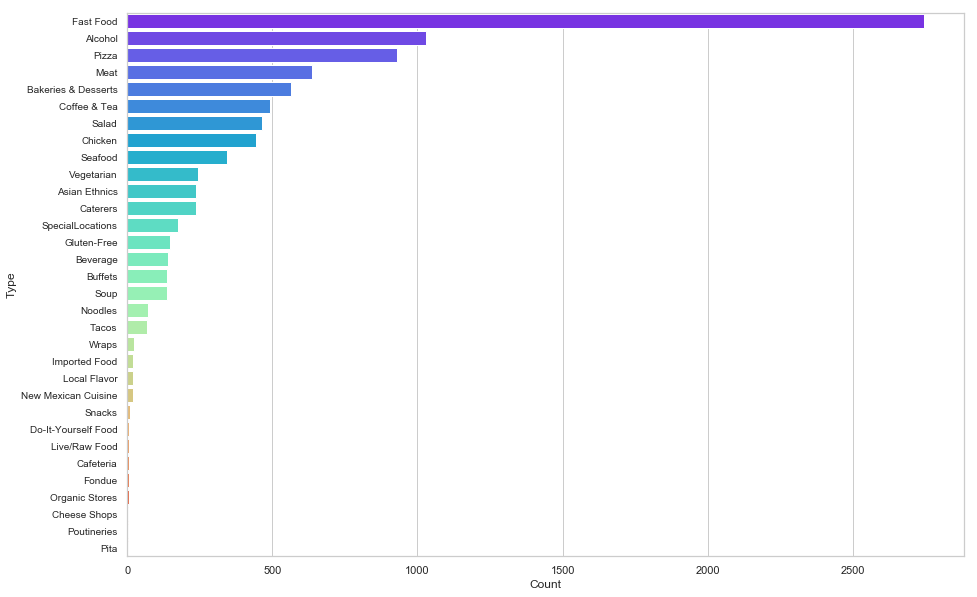

In [32]:
# Visualize dataframe types
plt.figure(figsize=(15,10))
sns.set(style='whitegrid')
types_plot = sns.barplot(x='Count', y='Type', data=type_df, palette ='rainbow')
types_plot.set_yticklabels(types_plot.get_yticklabels(), fontdict={'fontsize':10});

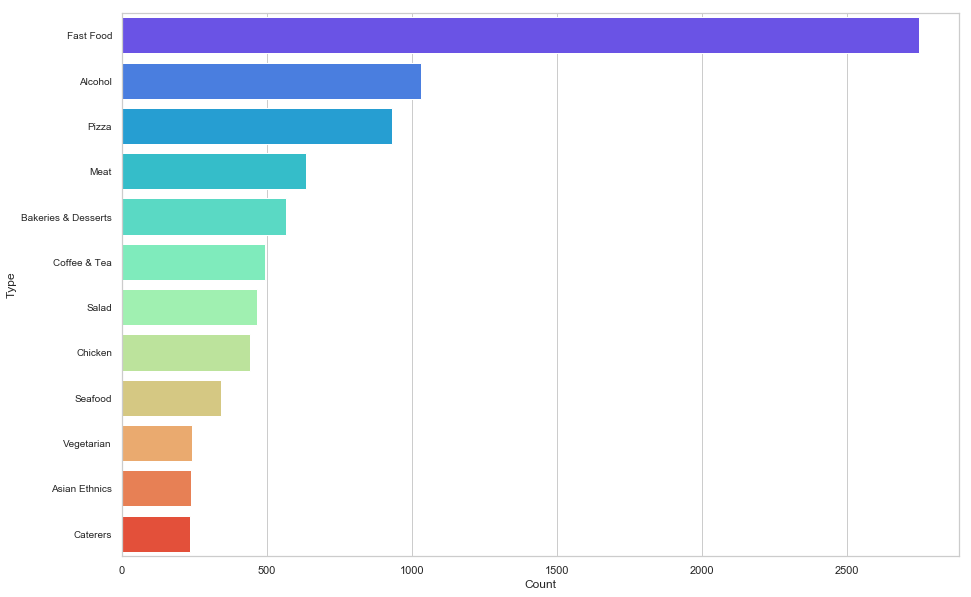

In [33]:
# Visualize dataframe types with more than 200 restaurants
plt.figure(figsize=(15,10))
sns.set(style='whitegrid')
types_plot = sns.barplot(x='Count', y='Type', data=type_df[type_df['Count']>200], palette ='rainbow')
types_plot.set_yticklabels(types_plot.get_yticklabels(), fontdict={'fontsize':10});

In [34]:
# Reveal first few rows
df_business['types'].head(10)

0               [Fast Food]
1               [Fast Food]
2               [Fast Food]
3                   [Pizza]
4    [Gluten-Free, Seafood]
5                 [Seafood]
6         [Fast Food, Meat]
7        [Fast Food, Pizza]
8        [Alcohol, Noodles]
9                 [Noodles]
Name: types, dtype: object

### Restaurant categories III - By Time of The Day 

In [35]:
time = ['Bed & Breakfast', 'Breakfast & Brunch', 'Dinner Theater', 'Nightlife']

In [36]:
df_business['time'] = df_business['categories'].apply(lambda row: [x for x in row if x in time])

In [37]:
df_business['time'].value_counts()

[]                                 5473
[Nightlife]                         859
[Breakfast & Brunch]                666
[Breakfast & Brunch, Nightlife]      58
[Nightlife, Breakfast & Brunch]      54
[Dinner Theater, Nightlife]           4
[Nightlife, Bed & Breakfast]          1
[Bed & Breakfast]                     1
Name: time, dtype: int64

In [38]:
for row in df_business['time']:
    for n,i in enumerate(row):
        if i=='Bed & Breakfast':
            row[n]='Breakfast'  

for row in df_business['time']:
    for n,i in enumerate(row):
        if i=='Breakfast & Brunch':
            row[n]='Breakfast'
            row.append('Brunch')

for row in df_business['time']:
    for n,i in enumerate(row):
        if i=='Dinner Theater':
            row[n]='Dinner'

for row in df_business['time']:
    for n,i in enumerate(row):
        if i=='Nightlife':
            row[n]='Dinner'
            row.append('Latenight')

In [39]:
# Take time to run!!
# Delete duplicates in feature time
df_business['time'] = df_business['time'].apply(lambda row: np.unique(row))

In [40]:
df_business['time'].head(10)

0                     []
1                     []
2                     []
3                     []
4                     []
5                     []
6                     []
7                     []
8    [Dinner, Latenight]
9                     []
Name: time, dtype: object

## Extract Features From Attributes

### Processing For Attributes

In [41]:
# Convert feature attributes to a dataframe
attributes_df = df_business['attributes'].apply(pd.Series)

In [42]:
attributes_df.head()

,RestaurantsTableService,GoodForMeal,Alcohol,Caters,HasTV,RestaurantsGoodForGroups,NoiseLevel,WiFi,RestaurantsAttire,RestaurantsReservations,...,GoodForDancing,Music,BestNights,CoatCheck,Smoking,ByAppointmentOnly,RestaurantsCounterService,AgesAllowed,AcceptsInsurance,HairSpecializesIn
0,False,"{'dessert': False, 'latenight': False, 'lunch'...",none,False,True,True,loud,free,casual,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,True,"{'dessert': False, 'latenight': False, 'lunch'...",full_bar,True,True,True,average,free,casual,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,False,"{'dessert': False, 'latenight': True, 'lunch':...",none,False,False,True,loud,paid,casual,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,True,"{'dessert': False, 'latenight': False, 'lunch'...",full_bar,True,True,True,average,free,casual,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
attributes_df.isna().sum()[attributes_df.isna().sum() < attributes_df.shape[0]/2]

RestaurantsTableService       1106
GoodForMeal                    641
Alcohol                        948
Caters                        1517
HasTV                          695
RestaurantsGoodForGroups       404
NoiseLevel                    1220
WiFi                          1108
RestaurantsAttire              546
RestaurantsReservations        390
OutdoorSeating                 588
BusinessAcceptsCreditCards     113
RestaurantsPriceRange2         298
BikeParking                    780
RestaurantsDelivery            395
Ambience                       754
RestaurantsTakeOut             277
GoodForKids                    401
BusinessParking                810
WheelchairAccessible          3356
dtype: int64

In [44]:
attributes_df.isna().sum()[attributes_df.isna().sum() >= attributes_df.shape[0]/2]

DriveThru                    5554
BusinessAcceptsBitcoin       6384
Open24Hours                  7033
BYOBCorkage                  6712
BYOB                         6872
Corkage                      6934
DogsAllowed                  5991
DietaryRestrictions          7085
HappyHour                    6249
GoodForDancing               6260
Music                        6296
BestNights                   6402
CoatCheck                    6314
Smoking                      6356
ByAppointmentOnly            6980
RestaurantsCounterService    6994
AgesAllowed                  7103
AcceptsInsurance             7111
HairSpecializesIn            7114
dtype: int64

We will keep all the features with total number of missing values less than half of the total number of observations except `WheelchairAccessible`. For rest features, we will only keep several useful features based on human judgement, which are `DriveThru`, `HappyHour` and `Smoking`.

In [45]:
# Drop unnecessary variables
attributes_df=attributes_df.drop(['WheelchairAccessible','BusinessAcceptsBitcoin','Open24Hours','BYOBCorkage',
                                 'BYOB','Corkage','DogsAllowed','DietaryRestrictions','GoodForDancing',
                                 'Music','BestNights','CoatCheck','ByAppointmentOnly','RestaurantsCounterService',
                                 'AgesAllowed','AcceptsInsurance','HairSpecializesIn'], axis=1)

In [46]:
attributes_df.head()

,RestaurantsTableService,GoodForMeal,Alcohol,Caters,HasTV,RestaurantsGoodForGroups,NoiseLevel,WiFi,RestaurantsAttire,RestaurantsReservations,...,RestaurantsPriceRange2,BikeParking,RestaurantsDelivery,Ambience,RestaurantsTakeOut,GoodForKids,DriveThru,BusinessParking,HappyHour,Smoking
0,False,"{'dessert': False, 'latenight': False, 'lunch'...",none,False,True,True,loud,free,casual,False,...,1.0,True,False,"{'romantic': False, 'intimate': False, 'classy...",True,True,True,"{'garage': False, 'street': False, 'validated'...",NaN,NaN
1,True,"{'dessert': False, 'latenight': False, 'lunch'...",full_bar,True,True,True,average,free,casual,False,...,2.0,True,True,"{'romantic': False, 'intimate': False, 'classy...",True,True,False,"{'garage': False, 'street': False, 'validated'...",NaN,NaN
2,False,"{'dessert': False, 'latenight': True, 'lunch':...",none,False,False,True,loud,paid,casual,False,...,1.0,False,False,"{'romantic': False, 'intimate': False, 'classy...",True,True,True,"{'garage': False, 'street': False, 'validated'...",NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,True,"{'dessert': False, 'latenight': False, 'lunch'...",full_bar,True,True,True,average,free,casual,True,...,2.0,True,True,"{'romantic': False, 'intimate': False, 'classy...",True,True,NaN,"{'garage': False, 'street': False, 'validated'...",NaN,NaN


In [47]:
attributes_df.columns

Index(['RestaurantsTableService', 'GoodForMeal', 'Alcohol', 'Caters', 'HasTV',
       'RestaurantsGoodForGroups', 'NoiseLevel', 'WiFi', 'RestaurantsAttire',
       'RestaurantsReservations', 'OutdoorSeating',
       'BusinessAcceptsCreditCards', 'RestaurantsPriceRange2', 'BikeParking',
       'RestaurantsDelivery', 'Ambience', 'RestaurantsTakeOut', 'GoodForKids',
       'DriveThru', 'BusinessParking', 'HappyHour', 'Smoking'],
      dtype='object')

In [48]:
# Change names for some variables
attributes_df = attributes_df.rename(columns={'RestaurantsTableService':'tableService','GoodForMeal':'openFor',
                                             'Alcohol':'alcohol','Caters':'caters','HasTV':'hasTV',
                                             'RestaurantsGoodForGroups':'forGroups','NoiseLevel':'noiceLevel',
                                             'WiFi':'hasWiFi','RestaurantsAttire':'attire',
                                              'RestaurantsReservations':'reservations','OutdoorSeating':
                                              'outdoorSeating','BusinessAcceptsCreditCards':'acceptCreditCard',
                                             'RestaurantsPriceRange2':'priceRange','BikeParking':'bikeParking',
                                             'RestaurantsDelivery':'delivery','Ambience':'ambience',
                                             'RestaurantsTakeOut':'hasTakeOut','GoodForKids':'goodForKids',
                                             'DriveThru':'driveThru','BusinessParking':'businessParking',
                                             'HappyHour':'happyHour','Smoking':'smoking'})

In [49]:
# Reveal first few rows
attributes_df.head()

,tableService,openFor,alcohol,caters,hasTV,forGroups,noiceLevel,hasWiFi,attire,reservations,...,priceRange,bikeParking,delivery,ambience,hasTakeOut,goodForKids,driveThru,businessParking,happyHour,smoking
0,False,"{'dessert': False, 'latenight': False, 'lunch'...",none,False,True,True,loud,free,casual,False,...,1.0,True,False,"{'romantic': False, 'intimate': False, 'classy...",True,True,True,"{'garage': False, 'street': False, 'validated'...",NaN,NaN
1,True,"{'dessert': False, 'latenight': False, 'lunch'...",full_bar,True,True,True,average,free,casual,False,...,2.0,True,True,"{'romantic': False, 'intimate': False, 'classy...",True,True,False,"{'garage': False, 'street': False, 'validated'...",NaN,NaN
2,False,"{'dessert': False, 'latenight': True, 'lunch':...",none,False,False,True,loud,paid,casual,False,...,1.0,False,False,"{'romantic': False, 'intimate': False, 'classy...",True,True,True,"{'garage': False, 'street': False, 'validated'...",NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,...,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,True,"{'dessert': False, 'latenight': False, 'lunch'...",full_bar,True,True,True,average,free,casual,True,...,2.0,True,True,"{'romantic': False, 'intimate': False, 'classy...",True,True,NaN,"{'garage': False, 'street': False, 'validated'...",NaN,NaN


### Restaurant categories III - By Time of The Day - Continue
We notice that feature `time` have values in dictionary format. we will break the dictionaries and convert them lists. 

In [50]:
# Convert feature time to a dataframe
openFor_df = attributes_df['openFor'].apply(pd.Series)

/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/api.py:107: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  result = result.union(other)
/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/api.py:69: RuntimeWarning: '<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects
  index = _union_indexes(indexes, sort=sort)
/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/api.py:107: RuntimeWarning: '<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects
  result = result.union(other)


In [51]:
# Reveal first few rows
openFor_df.head()

,dessert,latenight,lunch,dinner,breakfast,brunch,0
0,False,False,True,False,True,False,NaN
1,False,False,False,True,False,False,NaN
2,False,True,True,True,True,False,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,False,False,False,True,False,False,NaN


In [52]:
# Drop unnecessary variable
openFor_df = openFor_df.drop(0,axis=1)

In [53]:
# Check NA's
openFor_df.isna().sum()

dessert      641
latenight    641
lunch        641
dinner       641
breakfast    641
brunch       641
dtype: int64

In [54]:
# Fill NA's
openFor_df['dessert'] = openFor_df['dessert'].fillna(df_business['types'].apply(lambda row: 'Desserts' in row))
openFor_df['latenight'] = openFor_df['latenight'].fillna(df_business['time'].apply(lambda row: 'Latenight' in row))
openFor_df['lunch'] = openFor_df['lunch'].fillna(df_business['time'].apply(lambda row: 'Lunch' in row))
openFor_df['dinner'] = openFor_df['dinner'].fillna(df_business['time'].apply(lambda row: 'Dinner' in row))
openFor_df['breakfast'] = openFor_df['breakfast'].fillna(df_business['time'].apply(lambda row: 'Breakfast' in row))
openFor_df['brunch'] = openFor_df['brunch'].fillna(df_business['time'].apply(lambda row: 'Brunch' in row))

In [55]:
# Create new feature openTime with a series of lists
openFor_df['time'] = pd.Series()
openFor_df['time'] = openFor_df['time'].apply(lambda x: [])

In [56]:
# Convert several features into one
openFor_ls = ['latenight','lunch','dinner','breakfast','brunch']
for i in range(len(openFor_df['time'])):
    for j in openFor_ls:
        if str(openFor_df[j].iloc[i])=='True':
            openFor_df['time'].iloc[i].append(j)

Now we will visualize feature `time`.

In [57]:
# Convert dictionary to dataframe
openFor_dict = dict(zip(openFor_ls, [[x in row for row in openFor_df['time']].count(True) for x in openFor_ls]))
openFor_plot_df = pd.DataFrame(list(openFor_dict.items()),columns=['openFor','Count']).sort_values('Count',ascending = False).reset_index()
openFor_plot_df = openFor_plot_df.drop('index', axis=1);

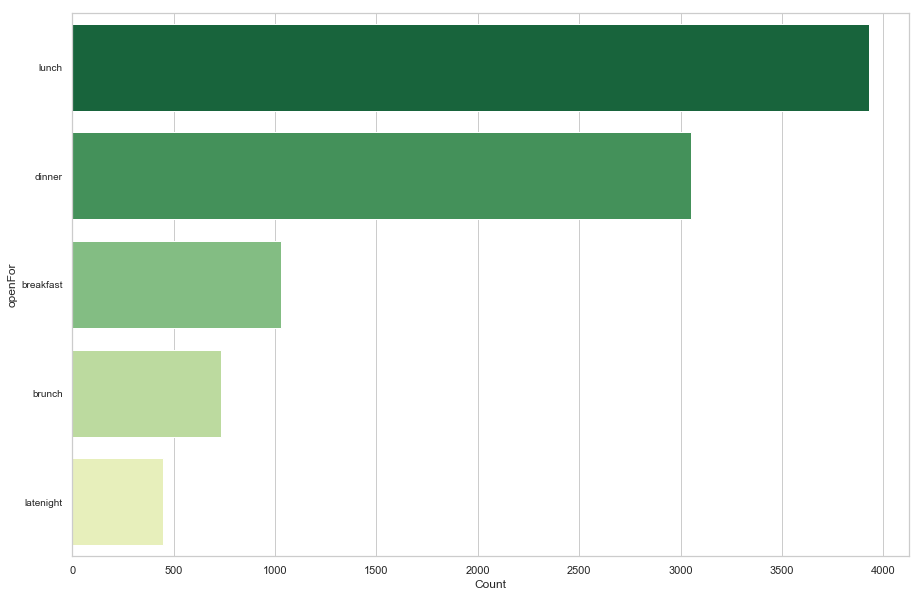

In [58]:
# Visualize dataframe types
plt.figure(figsize=(15,10))
sns.set(style='whitegrid')
openFor_plot = sns.barplot(x='Count', y='openFor', data=openFor_plot_df,palette='YlGn_r')
openFor_plot.set_yticklabels(openFor_plot.get_yticklabels(), fontdict={'fontsize':10});

In [59]:
openFor_df['time'].head()

0                       [lunch, breakfast]
1                                 [dinner]
2    [latenight, lunch, dinner, breakfast]
3                                       []
4                                 [dinner]
Name: time, dtype: object

Now, we will drop our original feature `time` and replace it with new `time` extracted from `attributes`. At the same time, we will also merge feature `dessert` in our business dataset.

In [60]:
# Drop variables
df_business = df_business.drop('time',axis=1)
attributes_df = attributes_df.drop('openFor', axis=1)
openFor_df = openFor_df.drop(['latenight','lunch','dinner','breakfast','brunch'], axis=1)

In [61]:
# Merge to our data
df_business = df_business.merge(openFor_df, left_index=True, right_index=True)

In [62]:
df_business.head().iloc[:,11:20]

,isBankrupt,county,isChain,density,ethnics,types,dessert,time
0,0,Maricopa County,1,2493,[],[Fast Food],False,"[lunch, breakfast]"
1,0,Maricopa County,0,2493,[],[Fast Food],False,[dinner]
2,0,Maricopa County,1,2493,[],[Fast Food],False,"[latenight, lunch, dinner, breakfast]"
3,0,Maricopa County,0,2493,[],[Pizza],False,[]
4,0,Maricopa County,0,844,[SouthEastAisa],"[Gluten-Free, Seafood]",False,[dinner]


### Clean NA's For Alcohol

In [63]:
# Check number of NA's
attributes_df['alcohol'].isna().sum()

948

In [64]:
# Fill NA's
attributes_df['alcohol'] = attributes_df['alcohol'].fillna(df_business['types'].apply(lambda row: str('Alcohol' in row)))

In [65]:
# Check value counts
attributes_df['alcohol'].value_counts()

none             3405
full_bar         1896
False             903
beer_and_wine     867
True               45
Name: alcohol, dtype: int64

Now we will do some combinations: <br>
`none`, `False` -> `False` <br>
`full_bar`, `beer_and_wine`, `True` -> `True`.

In [66]:
# Combinations
attributes_df['alcohol'] = attributes_df['alcohol'].str.replace('none', 'False')
attributes_df['alcohol'] = attributes_df['alcohol'].str.replace('full_bar', 'True')
attributes_df['alcohol'] = attributes_df['alcohol'].str.replace('beer_and_wine', 'True')

In [67]:
# Convert values to boolean
attributes_df['alcohol'] = attributes_df['alcohol'].apply(lambda x: (x=='True'))

In [68]:
# Check value counts again
attributes_df['alcohol'].value_counts()

False    4308
True     2808
Name: alcohol, dtype: int64

### Break Dictionaries For Ambience and BusinessParking

In [69]:
# Break dictionary ambience
ambience_df = attributes_df['ambience'].apply(pd.Series)
ambience_df = ambience_df.drop(0,axis=1)

In [70]:
# Break dictionary businessParking
businessParking_df = attributes_df['businessParking'].apply(pd.Series)
businessParking_df = businessParking_df.drop(0,axis=1)

In [71]:
# Merge to attributes_df
attributes_df = attributes_df.merge(ambience_df, left_index=True, right_index=True)
ambience_df = ambience_df.merge(businessParking_df, left_index=True, right_index=True)

In [72]:
attributes_df = attributes_df.drop(['ambience','businessParking'], axis=1)

In [73]:
attributes_df.shape

(7116, 28)

## Final Merge And Output

In [74]:
df_business.shape

(7116, 19)

In [75]:
df_business = df_business.merge(attributes_df, left_index=True, right_index=True)

In [76]:
df_business.shape

(7116, 47)

In [77]:
df_business.columns

Index(['attributes', 'business_id', 'categories', 'city', 'latitude',
       'longitude', 'name', 'postal_code', 'review_count', 'stars', 'state',
       'isBankrupt', 'county', 'isChain', 'density', 'ethnics', 'types',
       'dessert', 'time', 'tableService', 'alcohol', 'caters', 'hasTV',
       'forGroups', 'noiceLevel', 'hasWiFi', 'attire', 'reservations',
       'outdoorSeating', 'acceptCreditCard', 'priceRange', 'bikeParking',
       'delivery', 'hasTakeOut', 'goodForKids', 'driveThru', 'happyHour',
       'smoking', 'romantic', 'intimate', 'classy', 'hipster', 'divey',
       'touristy', 'trendy', 'upscale', 'casual'],
      dtype='object')

In [78]:
df_business.to_csv('business_forEDA.csv', index=False)